In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import os
import shutil
import json
import io

# Inspect full image archive without extracting all files

In [2]:
root_path = '../../../train/image/'
filenames = []
paths = []
for file in os.listdir(root_path)[:]:
    if 'jpg' in file:
        filenames.append(file)
        paths.append(root_path + file)
df = pd.DataFrame({'filename': filenames, 'path': paths})
print(len(df))
df.sample(n=5)

191952


filename                             path
187886  176520.jpg  ../../../train/image/176520.jpg
96583   155775.jpg  ../../../train/image/155775.jpg
82727   056155.jpg  ../../../train/image/056155.jpg
102598  135070.jpg  ../../../train/image/135070.jpg
69313   134476.jpg  ../../../train/image/134476.jpg

# Basic EDA


### Inspect a few sample images and corresponding bounding boxes

In [3]:
samples = df['path'].sample(5)
annos = []
bboxes = []
images = []
for file in samples: 
    anno = open(file.replace('.jpg','.json').replace('/image/','/annos/')).read()
    anno = json.loads(anno)
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(file)
    images.append(img)

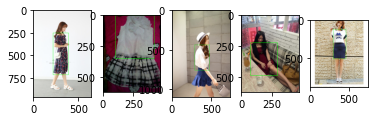

In [4]:
fig, ax = plt.subplots(1,len(samples))
i=0
for img, bbox in zip(images, bboxes):
    (x1, y1, x2, y2) = bbox
    img_bbox = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
    ax[i].imshow(img_bbox)
    i+=1
plt.show()

### Examine classes

In [5]:
%%time
ids = []
sources = []
scales = []
viewpoints = []
zooms = []
occlusions = []
landmarks = []
bboxes = []
styles = []
category_ids = []
category_names = []
annos = [f.replace('image', 'annos').replace('jpg', 'json') for f in df['path']]
print('# rows', len(annos))
for file in tqdm(annos): 
    anno = open(file).read()
    anno = json.loads(anno)
    
    for key in anno.keys():
        if 'item' in key:
            ids.append(file.split('/')[-1].split('.')[0])
            sources.append(anno['source'])
            #anno.keys() => dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])
            scales.append(anno[key]['scale'])
            viewpoints.append(anno[key]['viewpoint'])
            zooms.append(anno[key]['zoom_in'])
            occlusions.append(anno[key]['occlusion'])
            landmarks.append(anno[key]['landmarks'])
            bboxes.append(anno[key]['bounding_box'])
            styles.append(anno[key]['style'])
            category_ids.append(anno[key]['category_id'])
            category_names.append(anno[key]['category_name'])    

# rows 191952


  0%|          | 0/191952 [00:00<?, ?it/s]

CPU times: user 22.1 s, sys: 3.94 s, total: 26 s
Wall time: 1min


In [6]:
df_meta_all = pd.DataFrame(data=zip(ids, sources, scales, viewpoints, zooms, occlusions, landmarks, bboxes, styles, category_ids, category_names), columns=['id', 'source', 'scale', 'viewpoint', 'zoom', 'occlusion', 'landmarks', 'bbox', 'style', 'category_id', 'category_name'])
print(len(df_meta_all))
df_meta_all[:5]

312170


id source  scale  viewpoint  zoom  occlusion  \
0  064031   user      3          3     2          1   
1  092154   shop      2          2     3          2   
2  092154   shop      2          2     1          2   
3  077378   shop      1          2     1          2   
4  077378   shop      1          2     1          3   

                                           landmarks                  bbox  \
0  [210, 293, 1, 120, 292, 1, 177, 311, 2, 241, 3...   [17, 254, 442, 623]   
1  [359, 396, 1, 434, 382, 1, 484, 335, 1, 372, 4...  [354, 303, 571, 499]   
2  [336, 153, 1, 293, 177, 1, 324, 188, 2, 358, 1...  [255, 133, 501, 415]   
3  [266, 375, 1, 317, 377, 2, 382, 362, 1, 279, 5...  [254, 359, 397, 703]   
4  [292, 227, 1, 265, 230, 1, 276, 238, 1, 301, 2...  [211, 191, 413, 395]   

   style  category_id       category_name  
0      1           10  short sleeve dress  
1      0            8            trousers  
2      2            1    short sleeve top  
3      1            9               skirt  
4      0            1    short sleeve top

In [69]:
df_meta = df_meta_all.copy()

## Reference:  https://github.com/switchablenorms/DeepFashion2

Key fields:

- source: a string, where 'shop' indicates that the image is from commercial store while 'user' indicates that the image is taken by users.

- scale: a number, where 1 represents small scale, 2 represents modest scale and 3 represents large scale.

- occlusion: a number, where 1 represents slight occlusion(including no occlusion), 2 represents medium occlusion and 3 represents heavy occlusion.

- zoom_in: a number, where 1 represents no zoom-in, 2 represents medium zoom-in and 3 represents lagre zoom-in.

- viewpoint: a number, where 1 represents no wear, 2 represents frontal viewpoint and 3 represents side or back viewpoint.

First pass of training YOLOv5 on DF1 indicates that results including 'user' photos is very poor due to extreme viewing angles (down in mirror at jeans), heavy occlusion, etc.

Therefore, now filtering out 'poor quality' images.

In [57]:
def showSamples(samples):
    fig, ax = plt.subplots(1,len(samples), figsize=(15, 5))
    i=0
    for idx, row in samples.iterrows():
        img = Image.open(root_path+row.id+'.jpg')
        (x1, y1, x2, y2) = row.bbox
        img_bbox = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
        ax[i].imshow(img_bbox)
        ax[i].set_xlabel(row.source + '\n' + 
                         row.category_name +  
                         '\nScal:' + str(row.scale) + 
                         '\nOccl:' + str(row.occlusion) +
                         '\nZoom:' + str(row.zoom) + 
                         '\nView:' + str(row.viewpoint))
        ax[i].set_ylabel(row.id)
        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        ax[i].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

        i+=1
    plt.show()

In [58]:
source = ['user', 'shop']
scale = [1,2,3]
occlusion = [1,2,3]
zoom = [1,2,3]
viewpoint = [1,2,3]

def showFacets(facet, vals, n=5):
    for val in vals:
        samples = df_meta[df_meta[facet]==val].sample(n)
        print(facet, val)
        showSamples(samples)

source user


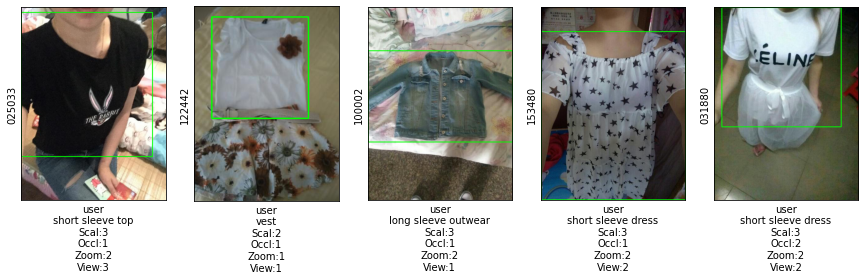

source shop


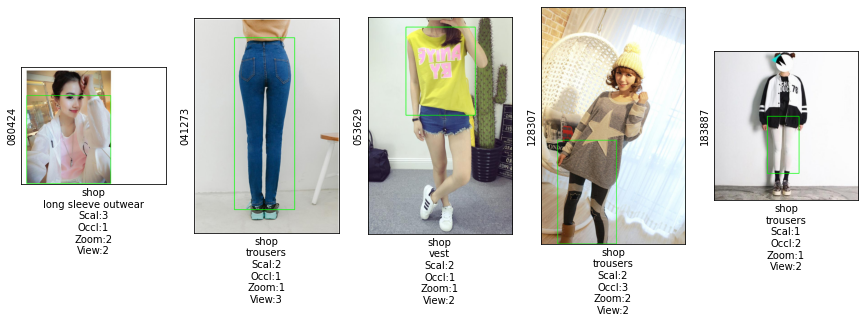

scale 1


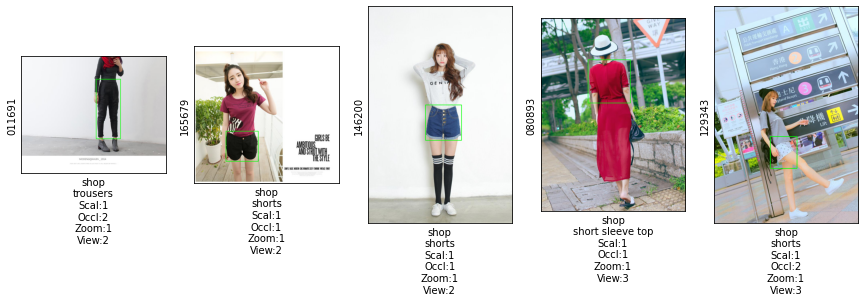

scale 2


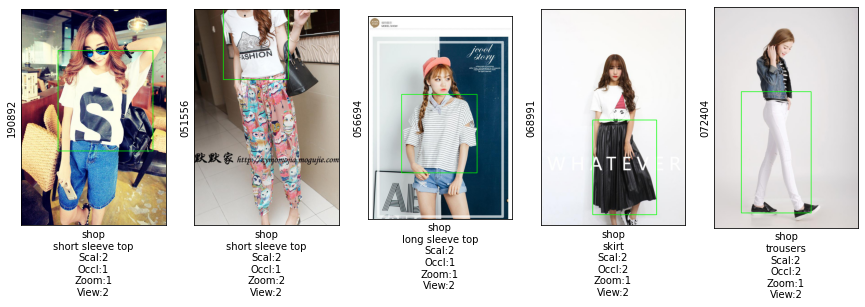

scale 3


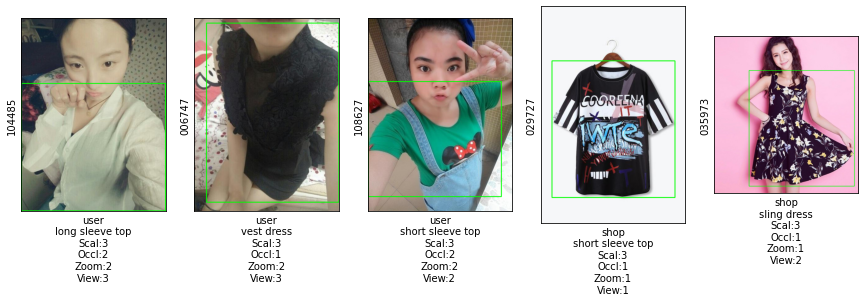

occlusion 1


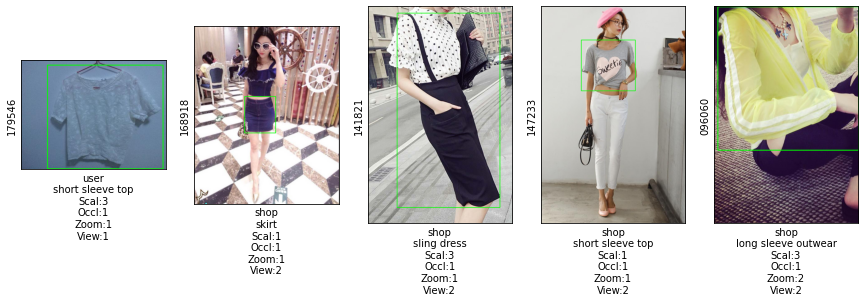

occlusion 2


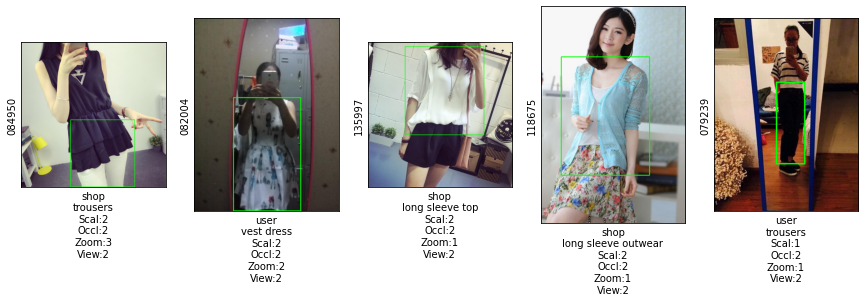

occlusion 3


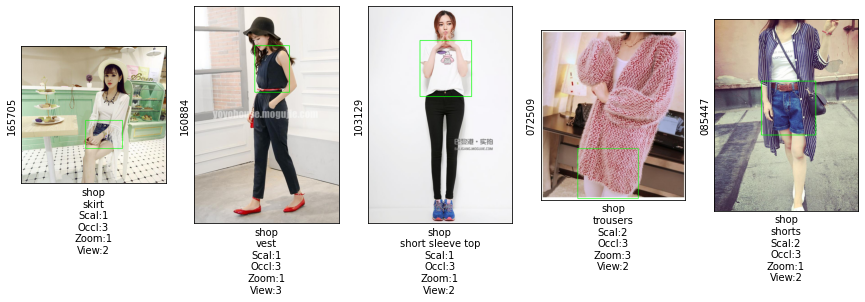

zoom 1


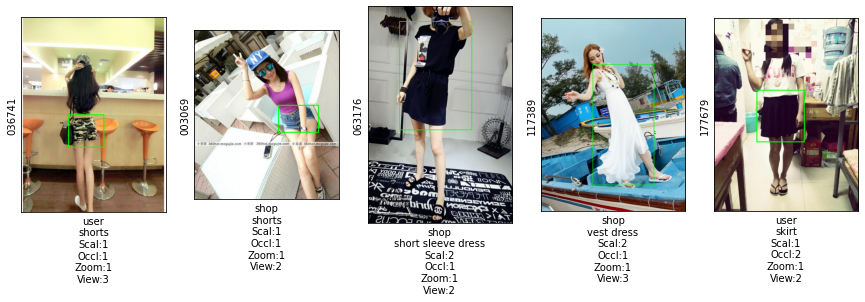

zoom 2


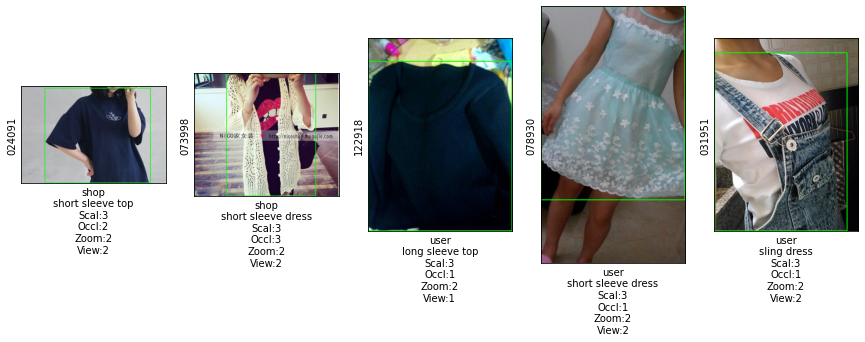

zoom 3


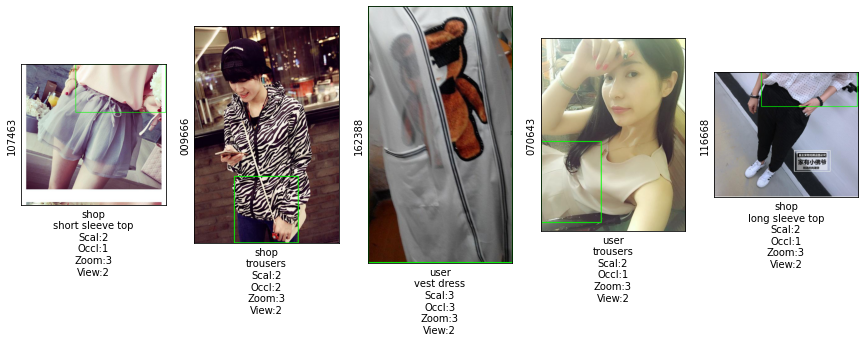

viewpoint 1


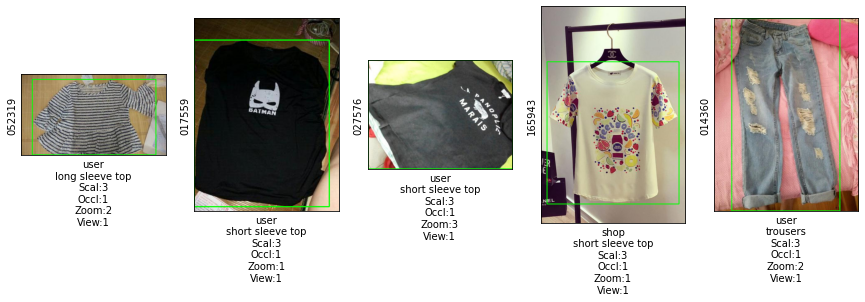

viewpoint 2


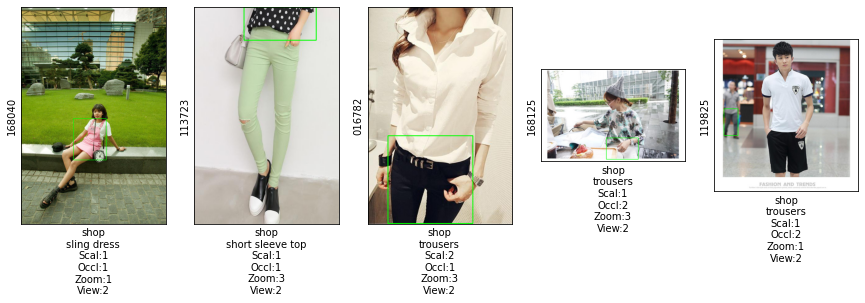

viewpoint 3


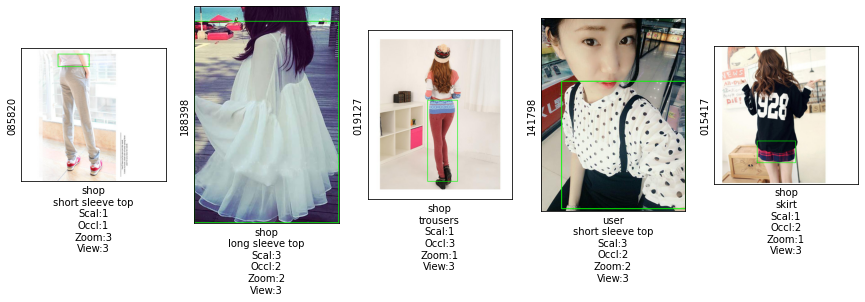

In [60]:
showFacets('source', source)
showFacets('scale', scale)
showFacets('occlusion', occlusion)
showFacets('zoom', zoom)
showFacets('viewpoint', viewpoint)

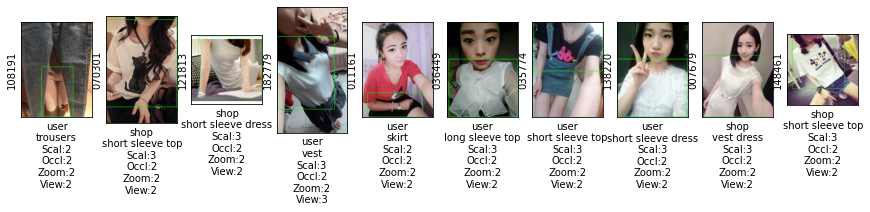

In [65]:
samps = df_meta[(df_meta.scale>=2) & 
                (df_meta.occlusion==2) & 
                (df_meta.zoom==2) & 
                (df_meta.viewpoint>=2)].sample(10)
showSamples(samps)

In [70]:
filter1 = (df_meta.occlusion<3) & (df_meta.zoom<3)
filter2 = (df_meta.scale>1) & (df_meta.occlusion==2) & (df_meta.zoom==2) & (df_meta.viewpoint>1)

In [71]:
df_meta = df_meta[filter1 & ~filter2]

In [72]:
cnts = df_meta.groupby('category_name').count().sort_values(by='id', ascending=False)
cnts

id  source  scale  viewpoint   zoom  occlusion  \
category_name                                                             
short sleeve top      56707   56707  56707      56707  56707      56707   
trousers              35374   35374  35374      35374  35374      35374   
long sleeve top       29120   29120  29120      29120  29120      29120   
shorts                28736   28736  28736      28736  28736      28736   
skirt                 23432   23432  23432      23432  23432      23432   
short sleeve dress    14518   14518  14518      14518  14518      14518   
vest dress            13434   13434  13434      13434  13434      13434   
vest                  13280   13280  13280      13280  13280      13280   
long sleeve outwear   11383   11383  11383      11383  11383      11383   
long sleeve dress      6548    6548   6548       6548   6548       6548   
sling dress            5352    5352   5352       5352   5352       5352   
sling                  1585    1585   1585       1585   1585       1585   
short sleeve outwear    474     474    474        474    474        474   

                      landmarks   bbox  style  category_id  
category_name                                               
short sleeve top          56707  56707  56707        56707  
trousers                  35374  35374  35374        35374  
long sleeve top           29120  29120  29120        29120  
shorts                    28736  28736  28736        28736  
skirt                     23432  23432  23432        23432  
short sleeve dress        14518  14518  14518        14518  
vest dress                13434  13434  13434        13434  
vest                      13280  13280  13280        13280  
long sleeve outwear       11383  11383  11383        11383  
long sleeve dress          6548   6548   6548         6548  
sling dress                5352   5352   5352         5352  
sling                      1585   1585   1585         1585  
short sleeve outwear        474    474    474          474

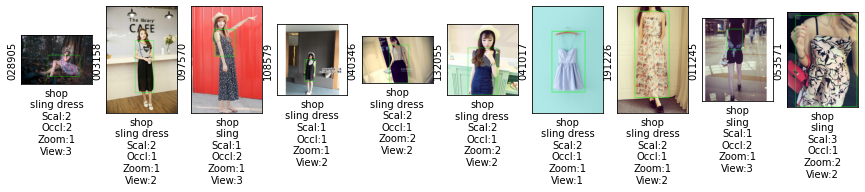

In [74]:
samps = df_meta[(df_meta.category_name.isin(['sling dress', 'sling', 'short sleeve outwear']))].sample(10)
showSamples(samps)

In [77]:
# combining 'sling' and 'sling dress' categories
df_meta.loc[df_meta.category_name=='sling','category_name'] = 'sling dress'

In [78]:
cnts = df_meta.groupby('category_name').count().sort_values(by='id', ascending=False)
cnts

id  source  scale  viewpoint   zoom  occlusion  \
category_name                                                             
short sleeve top      56707   56707  56707      56707  56707      56707   
trousers              35374   35374  35374      35374  35374      35374   
long sleeve top       29120   29120  29120      29120  29120      29120   
shorts                28736   28736  28736      28736  28736      28736   
skirt                 23432   23432  23432      23432  23432      23432   
short sleeve dress    14518   14518  14518      14518  14518      14518   
vest dress            13434   13434  13434      13434  13434      13434   
vest                  13280   13280  13280      13280  13280      13280   
long sleeve outwear   11383   11383  11383      11383  11383      11383   
sling dress            6937    6937   6937       6937   6937       6937   
long sleeve dress      6548    6548   6548       6548   6548       6548   
short sleeve outwear    474     474    474        474    474        474   

                      landmarks   bbox  style  category_id  
category_name                                               
short sleeve top          56707  56707  56707        56707  
trousers                  35374  35374  35374        35374  
long sleeve top           29120  29120  29120        29120  
shorts                    28736  28736  28736        28736  
skirt                     23432  23432  23432        23432  
short sleeve dress        14518  14518  14518        14518  
vest dress                13434  13434  13434        13434  
vest                      13280  13280  13280        13280  
long sleeve outwear       11383  11383  11383        11383  
sling dress                6937   6937   6937         6937  
long sleeve dress          6548   6548   6548         6548  
short sleeve outwear        474    474    474          474

In [80]:
len(df_meta)

239943

In [82]:
# filtering out categories with fewer than 5,000 samples
cats = cnts[cnts.id > 5000].index.values
print(len(cats))
cats

11


array(['short sleeve top', 'trousers', 'long sleeve top', 'shorts',
       'skirt', 'short sleeve dress', 'vest dress', 'vest',
       'long sleeve outwear', 'sling dress', 'long sleeve dress'],
      dtype=object)

In [83]:
subset = df_meta[df_meta.category_name.isin(cats)]

In [84]:
min_cnt = subset.groupby('category_name').count().min()[0]
min_cnt

6548

In [88]:
# Retaining 10,000 samples from the large categories to balance across all
samples = subset[subset.category_name.isin(cats[:-2])].groupby('category_name').sample(n=10000, random_state=314)

# for the full dataset we keep everythig
samples = samples.append(subset[subset.category_name.isin(cats[-2:])])

len(samples)

103485

In [89]:
df['id'] = df['filename'].apply(lambda x: x.split('.')[0])

In [90]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(samples, test_size=0.2)
#print(len(train),len(val))

#For this case, all the data is in the training set
train = samples

In [91]:
#val = pd.merge(df, val, on='id')
#val = val[val.folder=='image']
#len(val)

In [92]:
train = pd.merge(df, train, on='id')
len(train)

103485

In [93]:
train.iloc[0]

filename                                                064031.jpg
path                               ../../../train/image/064031.jpg
id                                                          064031
source                                                        user
scale                                                            3
viewpoint                                                        3
zoom                                                             2
occlusion                                                        1
landmarks        [210, 293, 1, 120, 292, 1, 177, 311, 2, 241, 3...
bbox                                           [17, 254, 442, 623]
style                                                            1
category_id                                                     10
category_name                                   short sleeve dress
Name: 0, dtype: object

In [94]:
root = '../../../'

if not os.path.exists(root+'df2_mix'):
    os.mkdir(root+'df2_mix')

if not os.path.exists(root+'df2_mix/images'):
    os.mkdir(root+'df2_mix/images')
if not os.path.exists(root+'df2_mix/images/train'):
    os.mkdir(root+'df2_mix/images/train')
if not os.path.exists(root+'df2_mix/images/val'):
    os.mkdir(root+'df2_mix/images/val')
if not os.path.exists(root+'df2_mix/images/test'):
    os.mkdir(root+'df2_mix/images/test')


if not os.path.exists(root+'df2_mix/labels'):
    os.mkdir(root+'df2_mix/labels')
if not os.path.exists(root+'df2_mix/labels/train'):
    os.mkdir(root+'df2_mix/labels/train')
if not os.path.exists(root+'df2_mix/labels/val'):
    os.mkdir(root+'df2_mix/labels/val')
if not os.path.exists(root+'df2_mix/labels/test'):
    os.mkdir(root+'df2_mix/labels/test')

In [95]:
target_dim = 640.0
 
def createFiles(data=train, type_='train'):
    for i, row in data.iterrows():
        if i%int(len(data)/100)==0:
            print(i)
        try:
            filepath = row.path
            img = Image.open(filepath)
            w_orig = float(img.size[0])
            h_orig = float(img.size[1])
            img.thumbnail((target_dim, target_dim)) 
            if 'png' in str(type(img)).lower():
                img = img.convert('RGB')
            img.save(root+'df2_mix/images/'+type_+'/'+row.filename, 'JPEG', optimize=True)

            (x1, y1, x2, y2) = [float(b) for b in row.bbox]
            x = round((((x2 - x1)/2) + x1) / w_orig, 4)
            y = round((((y2 - y1)/2) + y1) / h_orig, 4)
            w = round((x2 - x1) / w_orig, 4)
            h = round((y2 - y1) / h_orig, 4)

            idx = list(cats).index(row.category_name)
            metadata = str(idx) + f' {x} {y} {w} {h}'
            fileroot = root+'df2_mix/labels/'+type_+'/'+row.filename.split('.')[0]+'.txt'

            f = open(fileroot, 'w')
            f.write(metadata)
            f.close()
            img = None
        except:
            print('error:', row.path)

In [96]:
createFiles(train, type_='train')
#createFiles(val, type_='val')

0
1034
2068
3102
4136
5170
6204
7238
8272
9306
10340
11374
12408
13442
14476
15510
16544
17578
18612
19646
20680
21714
22748
23782
error: ../../../train/image/123236.jpg
24816
25850
26884
27918
28952
29986
31020
32054
33088
34122
35156
36190
37224
38258
39292
40326
41360
42394
43428
44462
45496
46530
47564
48598
49632
50666
51700
52734
53768
54802
55836
56870
57904
58938
59972
61006
62040
63074
64108
65142
66176
67210
error: ../../../train/image/121049.jpg
error: ../../../train/image/121049.jpg
68244
69278
70312
71346
72380
73414
74448
75482
76516
77550
78584
79618
80652
81686
82720
83754
84788
85822
86856
87890
88924
89958
90992
92026
93060
94094
95128
96162
97196
98230
99264
100298
101332
102366
103400


In [97]:
lines = []
lines.append('path: ../df2_mix # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  images/test\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open(root+'df2_mix/df2_mix.yaml', 'w')
f.writelines(lines)
f.close()